## Chroma multi-modal RAG

Many documents contain a mixture of content types, including text and images. 

The information captured in images is lost with naive RAG that does not specifically encode it.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

One approach:

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

Chroma recently has launched multi-modal support, enabling this: 

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use multimodal [Chroma](https://www.trychroma.com/) to embed images and text.

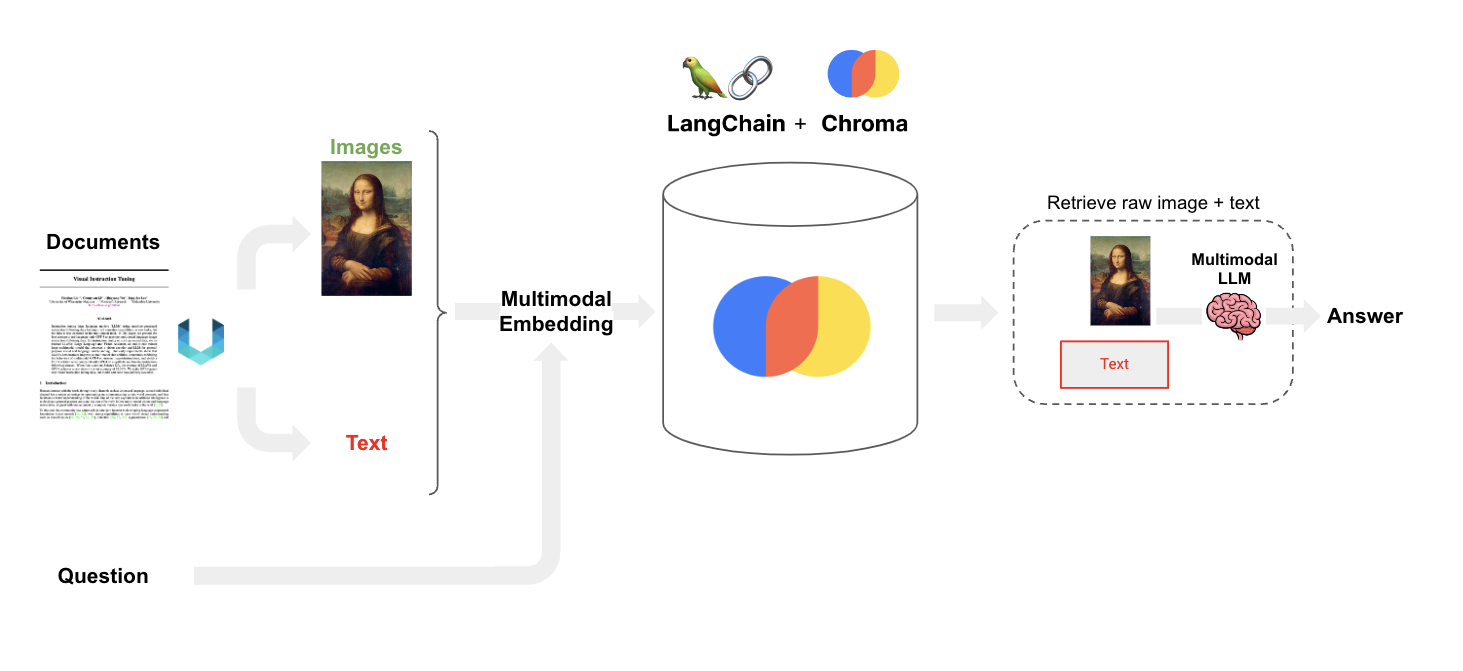

## Packages

In [ ]:
! pip install langchain unstructured[all-docs] pillow matplotlib openai chromadb

Ensure you are using openai SDK with vision: 

* https://github.com/openai/openai-python/releases/tag/v1.0.0
* https://platform.openai.com/docs/guides/vision

TODO: Ensure these are right

And have upgraded LangChain and Chroma for compatibility:
```
pip install "openai>=1.0.0"
pip install "langchain>=0.0.332"
pip install "chromadb>=0.4.16"
```

## Data Loading

### Partition PDF tables, text, and images
  
Let's look at an [example whitepaper](https://sgp.fas.org/crs/misc/IF10244.pdf) that provides a mixture of tables, text, and images about Wildfires in the US.

We use Unstructured to partition it (see [blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/)).

In [2]:
path = "/Users/rlm/Desktop/Multimodal_Eval/wildfire_stats/"

In [3]:
from lxml import html
from pydantic import BaseModel
from typing import Any, Optional
from unstructured.partition.pdf import partition_pdf

# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "wildfire_stats.pdf",
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Multi-modal Chroma

In [8]:
import os
import numpy as np
from PIL import Image as _PILImage
from langchain.vectorstores import Chroma
# from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

In [9]:
# Get images
image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
images = [np.array(_PILImage.open(path + f).convert("RGB")) for f in image_files]

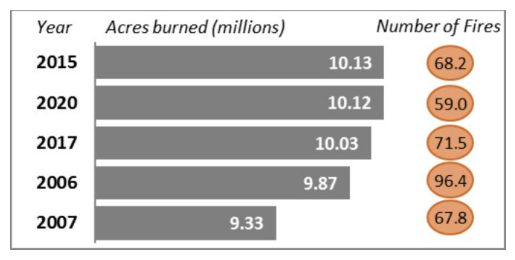

In [10]:
import matplotlib.pyplot as plt
# Display the first image
plt.imshow(images[0])
plt.axis('off')  # This will remove the axis and only show the image
plt.show()

In [ ]:
# Store in Chroma with multimodal embd

### TODO: Add Chroma multimodal
client = chromadb.Client()
embedding_function = OpenCLIPEmbeddingFunction()
collection = client.create_collection("mm_rag", embedding_function=embedding_function)

image_ids = [str(uuid.uuid4()) for _ in images]
collection.add(ids=image_ids, images=images)

text_ids = [str(uuid.uuid4()) for _ in texts]
collection.add(ids=text_ids, documents=texts)
collection.get(include=["documents"])

# Pass Chroma Client to LangChain
vectorstore = Chroma(
    client=client,
    collection_name="mm_rag",
    embedding_function=embedding_function,
)
retriever = vectorstore.as_retriever()

## RAG

In [ ]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

### TODO: Add LLM
model = ChatOpenAI(temperature=0, model="gpt-4")

# RAG pipeline
chain = (
    ### TODO: Split base64 encoded images from text chunks 
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)